# Deeplearning Summer School 2020 - Final Project Group 4

## Task 1 - Defining problem and dataset

### Imports

In [2]:
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns
import glob
import numpy as np 



from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from time import time
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Inspecting dataset in directory 

In [3]:
directory = 'C:/Users/jonad/deeplearning/dataset'
print(os.listdir(directory))

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1006.jpg', 'cat.1007.jpg', 'cat.1008.jpg', 'cat.1009.jpg', 'cat.101.jpg', 'cat.1010.jpg', 'cat.1011.jpg', 'cat.1012.jpg', 'cat.1013.jpg', 'cat.1014.jpg', 'cat.1015.jpg', 'cat.1016.jpg', 'cat.1017.jpg', 'cat.1018.jpg', 'cat.1019.jpg', 'cat.102.jpg', 'cat.1020.jpg', 'cat.1021.jpg', 'cat.1022.jpg', 'cat.1023.jpg', 'cat.1024.jpg', 'cat.1025.jpg', 'cat.1026.jpg', 'cat.1027.jpg', 'cat.1028.jpg', 'cat.1029.jpg', 'cat.103.jpg', 'cat.1030.jpg', 'cat.1031.jpg', 'cat.1032.jpg', 'cat.1033.jpg', 'cat.1034.jpg', 'cat.1035.jpg', 'cat.1036.jpg', 'cat.1037.jpg', 'cat.1038.jpg', 'cat.1039.jpg', 'cat.104.jpg', 'cat.1040.jpg', 'cat.1041.jpg', 'cat.1042.jpg', 'cat.1043.jpg', 'cat.1044.jpg', 'cat.1045.jpg', 'cat.1046.jpg', 'cat.1047.jpg', 'cat.1048.jpg', 'cat.1049.jpg', 'cat.105.jpg', 'cat.1050.jpg', 'cat.1051.jpg', 'cat.1052.jpg', 'cat.1053.jpg', 'cat.

### Loading Dataset into dataframes 

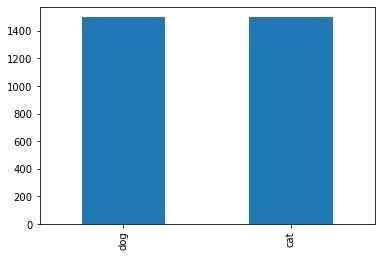

In [4]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

filenames = os.listdir(directory)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
df['category'].value_counts().plot.bar()



## Task 2 - Creating the datagenerators 

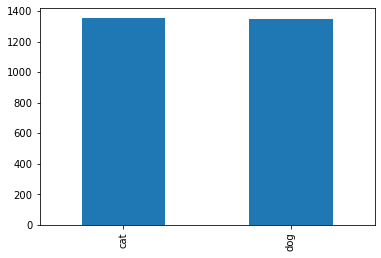

Found 300 validated image filenames belonging to 2 classes.


In [5]:
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df['category'].value_counts().plot.bar()
test_df['category'].value_counts().plot.bar()
plt.show()

total_train = train_df.shape[0]
# total_validate = validate_df.shape[0]
batch_size = 5

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



### Visualizing a random sample from the dataset (without augmentation) 

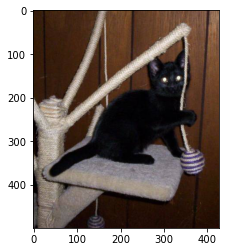

In [6]:
sample = random.choice(filenames)
image = load_img(directory + "/" + sample)
plt.imshow(image)


### Visualizing the data augmentation 

Found 1 validated image filenames belonging to 1 classes.


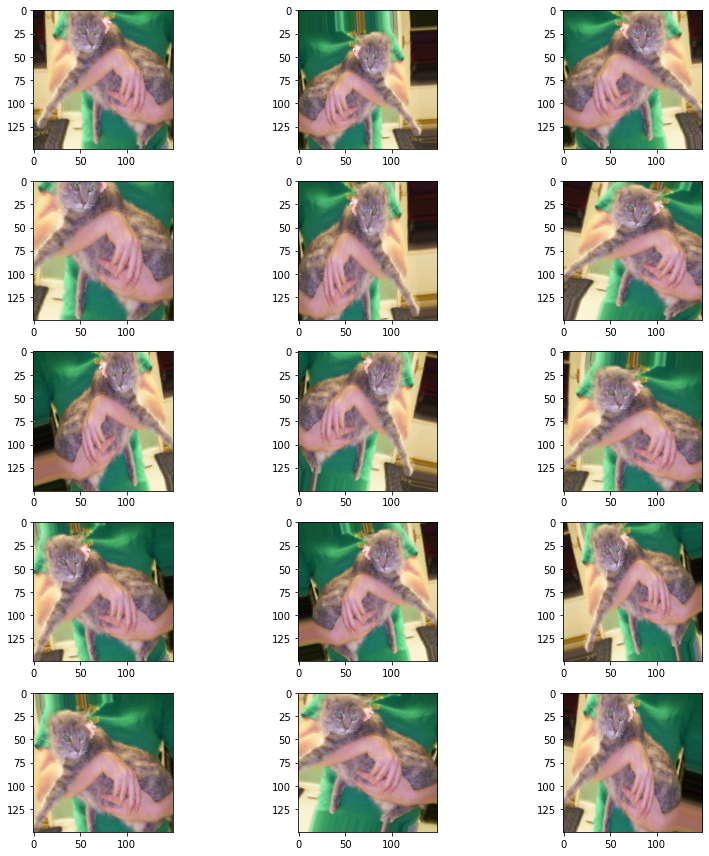

In [7]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    directory,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i + 1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## (Using an existing network - resnet(?) )

In [8]:
inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    
x = Conv2D(64, (7, 7), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))(inputs)
x_temp = x
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Add()([x, x_temp])
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)
x = Conv2D(64, (3, 3), padding = "same",  activation='relu')(x)

x = MaxPooling2D(pool_size=(5, 5))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x) # 2 because we have cat and dog classes

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.evaluate

NameError: name 'train_generator' is not defined

### Intermediate results from resnet 
loading and visualizing the intermediate results 

In [ ]:
path = r'C:\Users\jonad\deeplearning\results\resnet.csv' # use your path

frame3 = pd.read_csv(path, index_col=None, header=0)
frame3

## Task 3 - Constructing the network

In [ ]:
def define_model(
        nodes=16,
        loss='binary_crossentropy',
        opt="rmsprop",
        pooling=None,
        dropout=False,
        fc=1,
        act=tf.nn.relu,
        blocks=0
):

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

    x = Conv2D(64, (3, 3), activation=act, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))(inputs)

    for _ in range(0, blocks):
        x = Conv2D(64, (3, 3), padding="same", activation=act)(x)
        # if pooling == "MAX":
        x = MaxPooling2D(pool_size=(5, 5))(x)
        # if pooling == "AVG":
        #    x = AveragePooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    for _ in range(0, fc):
        x = Dense(nodes, activation=act)(x)

    if dropout:
        x = Dropout(0.2)(x)

    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    print(model.summary())

    return model

### Establishing callbacks 

In [ ]:
earlystop = EarlyStopping(patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

### Specifying parameters for Gridsearch 

In [ ]:
# Parameters for grid search
n_folds = 5  # Number of folds for K-fold CV
epochs = 50  # Number for model training epochs
batch = 5  # Batch size of the training
blocks = [1, 2, 3]  # Number of blocks (Conv2D + Pooling layers) in the model, by default 2
nodes = [128, 256, 512, 1024]  # List of the number of nodes for the gridseach - turned out 512 gave the best result 
FC_layers = [1, 2, 3]  # List of the number of fully connected layers after Flatten in the model
acts = ["sigmoid", "tanh", "relu"]  # List of activation functions used in the model - from Lorenzos test "tanh" gave the best result
poolings = ["MAX", "AVG"]  # List of poolings used in the model
opts = ["adam", "sgd", "rmsprop"]  # List of optimizers used in the model
# structure = "cnn"

information = True  # If True print completed model parameters and average accuracy for folds


### Creating a dataframe to hold the results 

In [ ]:
# Prepare DataFrame for results saving
Results = pd.DataFrame(columns=["Optimizer", "Fully Connected", "Activation", "Blocks", "Node", "AVG Train",
                                "AVG Valid", "AVG Test", "Time"])

### Initializing k-fold CV 

In [ ]:
# K-Fold CV
# prepare cross validation
kfold = KFold(n_folds, shuffle=True, random_state=1)
splits = kfold.split(train_df)

### Training Phase: k-fold & gridsearch 

In [ ]:
for o in opts:
    for fc in FC_layers:
        for a in acts:
            for b in blocks:
                for n in nodes:

                    start = time()
                    avg_train_acc = 0
                    avg_val_acc = 0
                    avg_test_acc = 0

                    print("*******************************************************************")
                    print(str(o) + " " + str(n))
                    print("*******************************************************************")

                    for train_ix, test_ix in kfold.split(train_df):
                        model = define_model(nodes=n, opt=o, blocks=1, fc=2, act='relu')

                        train_generator = train_datagen.flow_from_dataframe(
                            train_df.iloc[train_ix],
                            directory,
                            x_col='filename',
                            y_col='category',
                            target_size=IMAGE_SIZE,
                            class_mode='categorical',
                            batch_size=batch_size
                        )

                        validation_generator = train_datagen.flow_from_dataframe(
                            train_df.iloc[test_ix],
                            directory,
                            x_col='filename',
                            y_col='category',
                            target_size=IMAGE_SIZE,
                            class_mode='categorical',
                            batch_size=batch_size
                        )

                        history = model.fit(
                            train_generator,
                            verbose=2,
                            epochs=epochs,
                            validation_data=validation_generator,
                            callbacks=callbacks
                        )

                        _, acc = model.evaluate(train_generator)
                        print(f"Training Acc: {acc}")
                        avg_train_acc = avg_train_acc + acc

                        _, acc = model.evaluate(validation_generator)
                        print(f"Validation Acc: {acc}")
                        avg_val_acc = avg_val_acc + acc

                        _, acc = model.evaluate(test_generator)
                        print(f"Test Acc: {acc}")
                        avg_test_acc = avg_test_acc + acc

                        K.clear_session()
                        gc.collect()

                    Results = Results.append({"Optimizer": o,
                                              "Fully Connected": 2,
                                              "Activation": 'relu',
                                              "Blocks": 1,
                                              "Node": n,
                                              "AVG Train": avg_train_acc / n_folds,
                                              "AVG Valid": avg_val_acc / n_folds,
                                              "AVG Test": avg_test_acc / n_folds,
                                              "Time": time() - start},
                                             ignore_index=True)



### Saving the results externally 

In [ ]:
Results.to_csv("results/model_params.csv")

### Visualizing the differences to cnn and resnet default 

Explain here the conclusion we have drawn from the different attempts 

### Visualizing intermediate results from the csv file 
for efficiency reasons we decided to iterate the model in seperate steps on seperate group members pcs 
we then merged multiple csv files into one

In [ ]:
path = r'C:\Users\jonad\deeplearning\results' # use your path
all_files = glob.glob(path + "/p-*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame['Model'] = np.arange(1, len(frame)+1)
total_time_h = (frame["Time"].sum())/3600
frame.to_csv(r'C:\Users\jonad\deeplearning\results\all_models.csv', index = False)
frame

### Total training time 

In [ ]:
print("Total training time is:",total_time_h,  "hours")

In [ ]:
frame[frame['AVG Test']==frame['AVG Test'].max()]

### Changing parameters iteration 1 
the parameters above where obtained with 8 epochs. we tried with the same parameters but more epochs (50) to utilize the early stopping. 

In [ ]:
path = r'C:\Users\jonad\deeplearning\results\sgd_tanh_512_50epochs_3folds.csv' # use your path

frame2 = pd.read_csv(path, index_col=None, header=0)
frame2

### Changing parameters iteration 2
the following results were then obtained by setting the epochs down to 25 since early stopping always stopped at around 25 epochs. the number of folds was increased from 3 to 5 

In [ ]:
path = r'C:\Users\jonad\deeplearning\results\sgd_tanh_512_25epochs_5folds.csv' # use your path

frame3 = pd.read_csv(path, index_col=None, header=0)
frame3

### Changing parameters iteration 3
parameters were changed to 25 epochs and 5 folds, early stopping patience = 3

In [ ]:
path = r'C:\Users\jonad\deeplearning\results\sdg_tanh_512_25epochs_5folders_2blocks.csv' # use your path

frame4 = pd.read_csv(path, index_col=None, header=0)
frame4

### Making it fancy with seaborn

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))


# plot the average test accuracy for the corresponding models 
sns.set_color_codes("pastel")
sns.barplot(x="Model", y="AVG Test", data=frame,
            label="AVG Test Accuracy", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="Test accuracy",
       xlabel="Models obtained in gridsearch")
sns.despine(left=True, bottom=True)

In [ ]:
new = pd.melt(frame, id_vars=['Model', 'Optimizer', 'Fully Connected','Activation', 'Blocks', 'Node', 'AVG Train', 'AVG Valid'], value_vars=['AVG Test'])

In [ ]:
new_sort = new.sort_values(by='value', ascending=False)
new_sort

In [ ]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))


# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Model", y="value", data=new,
            hue='variable', 
            color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="Test accuracy",
       xlabel="Models obtained in gridsearch")
sns.despine(left=True, bottom=True)

### Retraining the model 

#### Loading the model 
loading a trained model as it was trained on a different pc 

In [9]:
model = tf.keras.models.load_model('C:/Users/jonad/deeplearning/model_81267.h5')

In [15]:
# Final model trained with fully augmented data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

final_generator = train_datagen.flow_from_dataframe(train_df,
directory,
x_col='filename',
y_col='category',
target_size=IMAGE_SIZE,
class_mode='categorical',
batch_size=batch_size, subset='training')

validation_generator = train_datagen.flow_from_dataframe(train_df,
directory,
x_col='filename',
y_col='category',
target_size=IMAGE_SIZE,
class_mode='categorical',
batch_size=batch_size, subset='validation')



history = model.fit(
     final_generator,
     epochs=epochs,
     steps_per_epoch=total_train//batch_size,
     callbacks=callbacks
     )

Found 2160 validated image filenames belonging to 2 classes.
Found 540 validated image filenames belonging to 2 classes.


NameError: name 'callbacks' is not defined

### Saving the model 

In [11]:
model.save("group4_final_model.h5")

## Task 4 - visualizing our results 

### Visualizing the Confusion matrix

In [12]:
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix


NameError: name 'confusion_matrix' is not defined

In [13]:
data = confusion_matrix(validation_generator.classes, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(validation_generator.classes), index = np.unique(validation_generator.classes))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

NameError: name 'confusion_matrix' is not defined

## Visualizing the wrongly classified images 

In [ ]:
incorrects = np.nonzero(model.predict_classes(x_test).reshape((-1,)) != y_test)
no = 5
plt.imshow(x_test[incorrects[0][no]].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[incorrects[0][no]].reshape(1, 28, 28, 1))
plt.title(f"Prediction: {pred.argmax()}")
plt.show()

### Visualizing training and validation accuracy 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Testing predictions

In [ ]:
# predicting images
img = keras.preprocessing.image.load_img('C:\Users\jonad\deeplearning\testdog.jpg', target_size=(150, 150))

x = keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")

In [ ]:
img2 = keras.preprocessing.image.load_img('C:\Users\jonad\deeplearning\testcat.jpg', target_size=(150, 150))
x = keras.preprocessing.image.img_to_array(img2)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")

In [ ]:
img3 = keras.preprocessing.image.load_img('C:\Users\jonad\deeplearning\testlion.jpg', target_size=(150, 150))
x = keras.preprocessing.image.img_to_array(img2)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")

In [ ]:
img4 = keras.preprocessing.image.load_img('C:\Users\jonad\deeplearning\testsandwich.jpg', target_size=(150, 150))
x = keras.preprocessing.image.img_to_array(img2)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print("Probabilities:",classes)

if (np.argmax(classes,axis=1)[0] == 1):
    print("DOG!")
if (np.argmax(classes,axis=1)[0] == 0):
    print("CAT!")

In [ ]:
history.history

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn.png' ,show_shapes=True, show_layer_names=True)

### Visualizing filter layers 

In [ ]:
model.summary()

layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

input_img = model.inputs[0]

layer_name = "conv2d_5" # change this according to which layer we want to see

for i in range(0,28):
    filter_index = i  # any filter of that layer

    layer_output = layer_dict[layer_name].output
    K.mean(layer_output[:, :, :, filter_index])
    K.gradients(loss, input_img)[0]

    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    output_dim = (412, 412)

    input_img_data = np.random.random((1, output_dim[0], output_dim[1], 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    input_img_data

    iterate.inputs

    for _ in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 1

    input_img_data -= input_img_data.mean()
    input_img_data /= (input_img_data.std() + K.epsilon())
    input_img_data *= 0.25

    # clip to [0, 1]
    input_img_data += 0.5
    input_img_data = np.clip(input_img_data, 0, 1)

    # convert to RGB array
    input_img_data *= 255
    input_img_data = np.clip(input_img_data, 0, 255).astype('uint8')

    def _draw_filters(filters, n=None, filter_index=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                width_margin: width_margin + output_dim[0],
                height_margin: height_margin + output_dim[1], :] = img


        # save the result to disk
        save_img('Filters/model_{0:}_{1:}x{1:}_f{2:}.png'.format(layer_name, n, filter_index), stitched_filters)

    Path("Filters").mkdir(parents=True, exist_ok=True)
    _draw_filters([(input_img_data, 0.1)], None,filter_index)

In [ ]:
nrows = 4
ncols = 7
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('Convolutional layer visualization for each filter', fontsize=16)
i = 0
j = 0
k = 0
for row in ax:
    for col in row:
        img=mpimg.imread(f'Filters/model_conv2d_12_1x1_f{i}.png')
        ax[j,k].imshow(img)
        ax[j,k].set_title(f"Filter {i}")
        ax[j,k].axes.xaxis.set_visible(False)
        ax[j,k].axes.yaxis.set_visible(False)
        i = i+ 1
        k = k +1
    j = j + 1
    k = 0

plt.show()